In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
import datasets
import numpy as np
import math

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1067.98it/s]


In [2]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [3]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_layers=4):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))
        t = torch.arange(-block_size, 0)
        self.register_buffer("alibi", torch.tril(torch.cat([t, t[:-1]]).unfold(0, len(t), 1).flip(0)))

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv(self.ln1(x)).chunk(3, dim=-1)
        w = q @ k.transpose(-2, -1) / math.sqrt(C) # (B, T, T)
        w = w + self.alibi[:T, :T]
        w.masked_fill_(self.mask[:T, :T], float("-Inf"))
        w = F.softmax(w, dim=-1)
        attn = self.proj(w @ v) # (B, T, C)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 207 K 
-------------------------------
207 K     Trainable params
0         Non-trainable params
207 K     Total params
0.829     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 24.25it/s]And nowR3ycFASb
 bgBO EYResfW;xZzKZzj $mArmT W;N$wxieWDuPqL.SObAhK, ;ry
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 209/209 [00:08<00:00, 26.03it/s, loss=1.75, v_num=176]And now.

PArd my to liming intenth.

ROGARET:
I'll dist asir, wondely 
Epoch 1: 100%|██████████| 209/209 [00:07<00:00, 27.00it/s, loss=1.57, v_num=176, test_loss=1.880]And now, think achile;
Both you sumstled, and must. Heared; banispirati
Epoch 2: 100%|██████████| 209/209 [00:07<00:00, 27.09it/s, loss=1.49, v_num=176, test_loss=1.720]And now a much thou had,
A spur, there as bear.

LADY Tis i' your came.
Epoch 3: 100%|██████████| 209/209 [00:07<00:00, 27.10it/s, loss=1.44, v_num=176, test_loss=1.610]And now with high aftertains,
As a pairise he in much his ginglish all 
Epoch 4: 100%|██████████| 209/209 [00:07<00:00, 27.24it/s, loss=1.41, v_num=176, test_loss=1.540]And now my lord!
I made me my heart that thou wilt some toil.

Roman:
N
Epoch 5: 100%|██████████| 209/209 [00:07<00:00, 27.17it/s, loss=1.39, v_num=176, test_loss=1.540]And now.

All:
Thou art to stay, I wae, my counterfess the scope,
And m
Epo

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 209/209 [00:10<00:00, 19.13it/s, loss=1.25, v_num=176, test_loss=1.410]


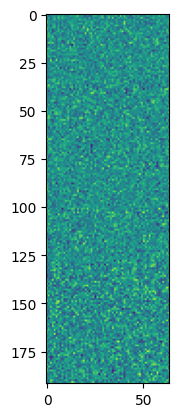

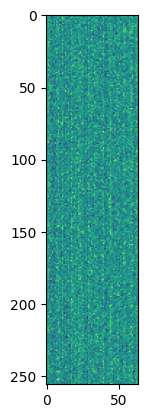

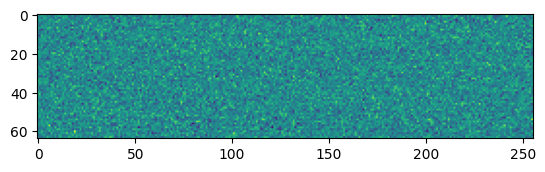

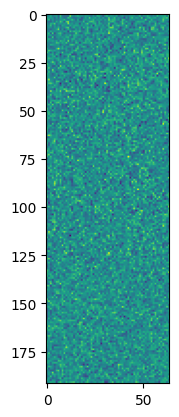

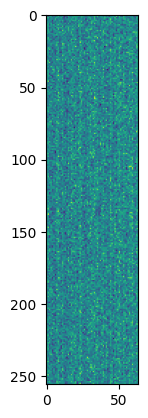

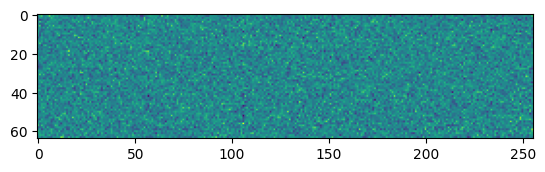

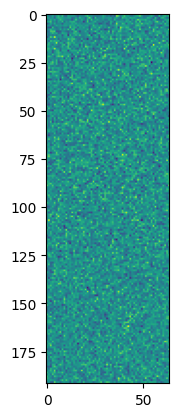

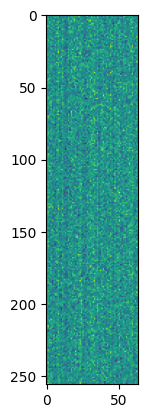

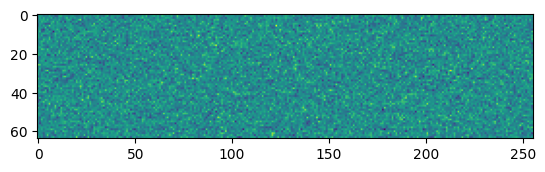

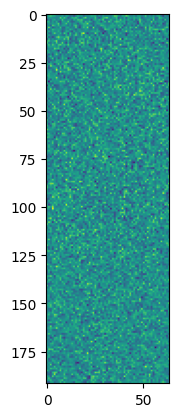

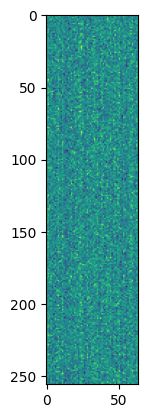

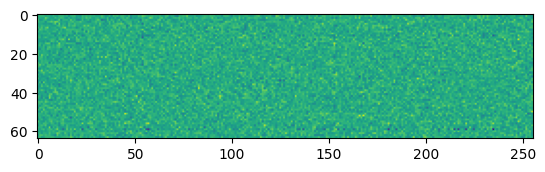

In [4]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.qkv.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [5]:
print(model.generate("O God, O God!", 1024))

O God, O God! what wicked the morselves? till thing may.

MERCUTIO:
Say?

LADY GRELO:
I thank you, dost thou gall oft be sights
Whilst I wander him, this shall
thankful hands to tell him being thou lion
Have at this whence thou canst hide me to says after's blind her!

COMINIUS:
He hath had rather; I promised: though I means how I love me in this sweet title affair'd
That is as I like this deliver, my good lord computy.

Shouldery:
And, as these moon the satisfied
Master than a bigger scorn'd and man
About the morning with mine honour to you?

MOPSA:
Sout of your highness; and there's for his soul's figure of the force to come
Bestride forth, for my hearts and do in all the blood against his signify is so, sir, were your pate,
To bear the garlicly move and stratagone.

GLOUCESTER:
So here hardy him to me? I'll please, her folthos,--
Whose honours fill'd, to my lord play'd his stay;
An end that you cannot be the general a wolves thither.

MOGS:
I humbly pound tongue to hers? I thinks, f